# ADVANTAGE ACTOR-CRITIC (*ONLINE POLICY*)
____

### Importing necessary packages

In [9]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Normal

In [10]:
m = Normal(torch.tensor([1.0]), torch.tensor([0.03]))
a = m.sample()
print(a)
print(m.log_prob(torch.tensor(1)))
print(a.squeeze(0).numpy())

tensor([1.0367])
tensor([2.5876])
1.0366755


In [11]:
env = gym.make('CartPole-v0')

### Analysing the Env

In [12]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print("State size : ",state_size," Action Size : ",action_size)
print("States details : ",env.observation_space)
print("Action details : ",env.action_space)

State size :  4  Action Size :  2
States details :  Box(4,)
Action details :  Discrete(2)


In [13]:
def t(x):
    return torch.from_numpy(x).float()

## Defining the Network 
___

In [2]:
class Actor(nn.Module):
    def __init__(self,input_size,out_size):
        super(Actor,self).__init__()
        
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,out_size)
    def forward(self,state):
        state = t(state)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim=0)

In [3]:
class Critic(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,1)
    def forward(self,state):
        state = t(state)
        x = F.leaky_relu(self.fc1(state))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
actor = Actor(state_size,action_size)
critic = Critic(state_size)
ac_opt = optim.Adam(actor.parameters(),lr=1e-4)
cr_opt = optim.Adam(critic.parameters(),lr=1e-3)

NameError: name 'state_size' is not defined

### Hyperparameters related to the Algorithm

In [5]:
gamma = 0.99
n_episodes = 1000

#  A2C Algorithm 
___

In [6]:
reward_per_ep = []
for ep in range(n_episodes):
    state = env.reset()
    score = 0
    for _ in range(1000):
        probs = actor(state)
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        next_state,reward,done,info = env.step(action.detach().data.numpy())
        
        advantage = reward + (1-done)*gamma*critic(next_state) - critic(state)
        ##advantage = reward + (1-done)*gamma*critic(state) - critic(next_state)
        
        critic_loss = advantage.pow(2).mean()
        cr_opt.zero_grad()
        critic_loss.backward()
        cr_opt.step()
        
        ## Throwing an entropy bonus to encourage exploration
        entropy_bonus = (probs*torch.log(probs)).sum()
        
        actor_loss = -dist.log_prob(action)*advantage.detach() + 0.0001*entropy_bonus
        #torch.nn.utils.clip_grad_norm_(actor.parameters(),5)
        ac_opt.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(actor.parameters(),8)
        ac_opt.step()
        
        state = next_state
        score += reward
        
        if done:
            break
    reward_per_ep.append(score)
    avg_last_100 = np.mean(reward_per_ep[-100:])
    print("\rEpisode {} ,\
Score : {} , \
Average Reward : {:3f} ,\
Average Reward of last 100 Episode : {:3f} ".format(ep+1,score,np.mean(reward_per_ep),
                                                             avg_last_100,end=""),end="")
    if (ep+1)%100 == 0 :
        print()
    if avg_last_100 > 195:
        print()
        print("Episode solved in ",ep+1)
        break

NameError: name 'env' is not defined

### Saving the model's parameter

In [29]:
torch.save(actor.state_dict,'checkpoint.pth')

C:\Users\Pratik Agarwal\anaconda3\envs\drlnd\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Actor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Loading a Saved Model

In [30]:
actor.state_dict = torch.load('checkpoint.pth')

## Visualizing the Results
___

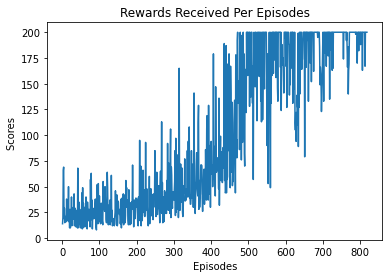

In [31]:
%matplotlib inline
plt.title('Rewards Received Per Episodes')
plt.plot(np.arange(len(reward_per_ep))+1,reward_per_ep,label='Score Per Episode')
plt.xlabel("Episodes")
plt.ylabel("Scores ")
plt.show()

## Visualizing after 500 episodes

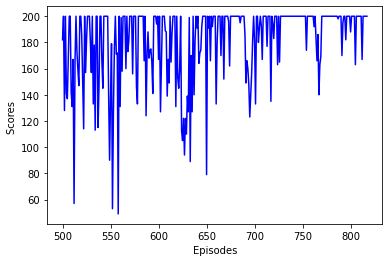

In [33]:
plt.plot(np.arange(len(reward_per_ep[500:]))+500,reward_per_ep[500:],label='score',Color='b')
plt.xlabel("Episodes")
plt.ylabel("Scores ")
plt.show()

## Watching an Trained Agent Play

In [34]:
state = env.reset()
score = 0 
actor.eval()
while True:
    probs = actor(state)
    env.render()
    action = np.random.choice(action_size,p=probs.detach().numpy())
    state,reward,done,_ = env.step(action)
    score+=reward
    if done:
        break
print("Score achieved = ",score)

Score achieved =  200.0


In [36]:
rewards = []
actor.eval()
for i in range(100):
    score = 0
    state = env.reset()
    while True:
        probs = actor(state)
        env.render()
        action = np.random.choice(action_size,p=probs.detach().numpy())
        state,reward,done,_ = env.step(action)
        score+=reward
        if done:
            break
    rewards.append(score)
print('Avg reward : ',np.mean(rewards))

Avg reward :  189.55
